# 出身地の記述を名寄せ

名寄せの仕組み自体と簡単なテストケースは、 `utils.py` の `identify_locations()` を参照のこと

In [1]:
import json
from collections import defaultdict

from utils import identify_locations

In [2]:
identify_locations("北海道札幌市中央区北1条東4丁目1-1サッポロファクトリー1条館3F")

('北海道', '札幌市中央区')

In [3]:
identify_locations("岩手県水沢市（現：奥州市）")

('岩手県', '奥州市')

---

In [4]:
with open("../data/workspace/page_locations_raw.json") as fp:
    page_locations_raw = json.load(fp)
len(page_locations_raw)

37739

In [5]:
page_locations_clean = {}
ambiguous_location_pages = defaultdict(list)

for page, locations_raw in sorted(page_locations_raw.items()):
    locations_clean_set = set()
    for before in locations_raw:
        after = identify_locations(before)
        if after:
            locations_clean_set.add(after)
        else:
            ambiguous_location_pages[before].append(page)
    if locations_clean_set:
        page_locations_clean[page] = sorted(locations_clean_set)

len(page_locations_clean)

16528

In [6]:
with open("../data/workspace/page_locations_clean.json", "w") as fp:
    json.dump(page_locations_clean, fp, indent=2, ensure_ascii=False)

In [7]:
!head ../data/workspace/page_locations_clean.json

{
  "%22brother%22YASSHI": [
    [
      "京都府",
      "宇治市"
    ]
  ],
  "%22黒天使%22沼澤邪鬼": [
    [
      "埼玉県",


In [8]:
# 対象ページ数が多い順にソート
ambiguous_location_pages = dict(sorted(ambiguous_location_pages.items(), key=lambda x: len(x[1]), reverse=True))

with open("../data/workspace/ambiguous_location_pages.json", "w") as fp:
    json.dump(ambiguous_location_pages, fp, indent=2, ensure_ascii=False)

## 名寄せできなかった地名表記

In [9]:
import pandas as pd

In [10]:
len(ambiguous_location_pages)

4569

- 情報粒度が荒いケース
  - 今回は「市区町村」レベルを求める
  - 「都道府県」のみでは対象外
  - 「政令指定都市」では「区」の単位まで求める
- 地名ではないケース（学校名等）
- 合併等により廃止された市区町村
- ...

In [11]:
len(ambiguous_location_pages["http://ja.dbpedia.org/resource/日本"])

3565

In [12]:
len(ambiguous_location_pages["北海道"])

66

In [13]:
len(ambiguous_location_pages["北海道札幌市"])

147

In [14]:
len(ambiguous_location_pages["http://ja.dbpedia.org/resource/吉本総合芸能学院"])

190

In [15]:
df = pd.DataFrame([(k, len(v)) for k, v in ambiguous_location_pages.items()], columns=["地名表記", "ページ数"])
df.head()

,地名表記,ページ数
0,http://ja.dbpedia.org/resource/日本,3565
1,http://ja.dbpedia.org/resource/東京都,2373
2,・東京都,1757
3,http://ja.dbpedia.org/resource/大阪府,1295
4,http://ja.dbpedia.org/resource/神奈川県,1212


In [16]:
df.tail()

,地名表記,ページ数
4564,（現：鹿児島県鹿児島市新屋敷町）,1
4565,（旧赤磐郡山陽町）,1
4566,宮城県仙台市（愛知県名古屋市）,1
4567,山口県三隅町,1
4568,長野県坂城町,1


1回のみ出現する表記が最も多い。出現回数はべき乗となっている。

In [17]:
df.groupby("ページ数").count().reset_index().sort_values("ページ数").rename(columns={"地名表記": "地名表記の数"})

,ページ数,地名表記の数
0,1,3702
1,2,371
2,3,113
3,4,74
4,5,34
...,...,...
146,1212,1
147,1295,1
148,1757,1
149,2373,1


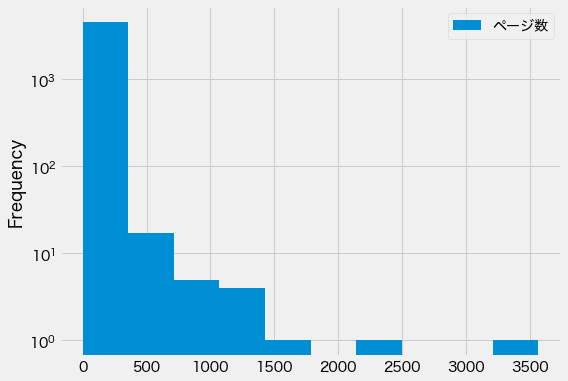

In [18]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Hiragino Sans"
plt.rcParams["figure.figsize"] = [8, 6]

df.plot.hist(log=True);